<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!nvidia-smi

Wed Mar 18 10:08:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from torch import nn, optim

In [0]:
def vgg_block(num_convs, in_channels, out_channels):
  blk = []
  for i in range(num_convs):
    if i == 0:
      blk.append(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
    else:
      blk.append(nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1))
    blk.append(nn.ReLU())
  blk.append(nn.MaxPool2d(kernel_size=2, stride=2))  # 这里会使宽高减半
  return nn.Sequential(*blk)   # 这里要加 * 

In [0]:
# 5.7.2 VGG 网络
# VGG 网络也是前面是卷积层模块，后接全连接模块。卷积层模块是数个vgg_block模块，数量是一个超参数由变量 conv_arch定义。该变量指定了每个VGG块里卷积层个数和输入输出通道数
# 全连接模块则跟AlexNet中的一样。  现在我们构造一个VGG，他有5个卷积块，前两块使用单卷积层，而后3块使用双卷积层。第一块的输入输出通道分别是1（因为下面要使用的Fashion-MNIST数据的通道数为1）
# 和64，之后每次对输出通道数翻倍，直到变为512。因为这个网络使用了8个卷积层和3个全连接层，所以经常称为VGG-11
conv_arch = ((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
# 经过5个vgg_block，宽高会减半5次，变成224/32 = 7
fc_features = 512*7*7   # c*w*h
fc_hidden_units = 4096   # 任意

In [0]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer, self).__init__()
  def forward(self, x): # x shape: (batch, *, *, ...)
    return x.view(x.shape[0], -1)

In [0]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
  net = nn.Sequential()
  for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
    # 每经过一个vgg_block都会使宽高减半
    net.add_module("vgg_block_"+str(i+1),vgg_block(num_convs, in_channels, out_channels))
  net.add_module("fc",nn.Sequential(
      FlattenLayer(),
      nn.Linear(fc_features, fc_hidden_units),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(fc_hidden_units, fc_hidden_units),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(fc_hidden_units,10)
  ))
  return net

In [21]:
# 下面构造一个高和宽均为224的单通道数据样本来观察每一层的输出形状
net = vgg(conv_arch, fc_features,fc_hidden_units)
X = torch.rand(1,1,224,224)

print(net.named_children())
# named_children获取一级子模块及其名字（named_modules会返回所有子模块，包括子模块的子模块
for name, blk in net.named_children():
  X = blk(X)
  print(name, "output shape:",X.shape)

<generator object Module.named_children at 0x7ff2af08ae60>
vgg_block_1 output shape: torch.Size([1, 64, 112, 112])
vgg_block_2 output shape: torch.Size([1, 128, 56, 56])
vgg_block_3 output shape: torch.Size([1, 256, 28, 28])
vgg_block_4 output shape: torch.Size([1, 512, 14, 14])
vgg_block_5 output shape: torch.Size([1, 512, 7, 7])
fc output shape: torch.Size([1, 10])


In [22]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Dataset/FashionMNIST',train=True,download=True,transform=transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor()
]))
mnist_test = torchvision.datasets.FashionMNIST(root='~/Dataset/FashionMNIST',train=False,download=True,transform=transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor()
]))
print(type(mnist_train),type(mnist_test))
print(len(mnist_train),len(mnist_test))

Using downloaded and verified file: /root/Dataset/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting /root/Dataset/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Dataset/FashionMNIST/FashionMNIST/raw



Extracting /root/Dataset/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Dataset/FashionMNIST/FashionMNIST/raw



Extracting /root/Dataset/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Dataset/FashionMNIST/FashionMNIST/raw



Extracting /root/Dataset/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Dataset/FashionMNIST/FashionMNIST/raw
Processing...
Done!
<class 'torchvision.datasets.mnist.FashionMNIST'> <class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [23]:
# 可以用索引来访问数据集具体数据
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 224, 224]) 9


In [0]:
from PIL import Image

# loader使用torchvision中自带的transforms函数
loader = transforms.Compose([
    transforms.ToTensor()])  

unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

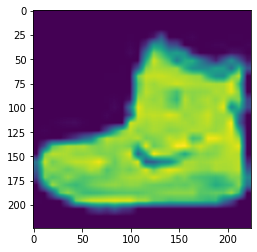

In [25]:
imshow(feature)

In [0]:
# 输入tensor变量
# 输出PIL格式图片
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

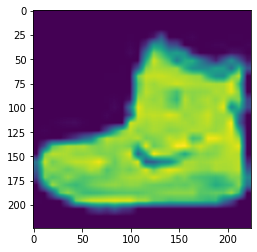

In [27]:
plt.imshow(tensor_to_PIL(feature))
plt.show()

In [0]:
# 读取小批量
batch_size =32
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)

In [0]:
import torchvision.models as models

In [30]:
# net = models.vgg11(pretrained=True)
#　vgg中的 avgpool 层是自适应均值卷积层，相当于卷积的方式是取均值，自适应是我限定了输出的尺寸，你自己来给我搞定。
print(net)
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
num_epochs = 5


Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [0]:
# import torch.nn as nn
# net_features = net.features
# print(net_features[0])
# net_features[0] = nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(1,1), padding=(1,1))
# net_features[3] = nn.Conv2d(8, 16, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# net_features[6] = nn.Conv2d(16, 32, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# net_features[8] = nn.Conv2d(32, 32, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# net_features[11] = nn.Conv2d(32, 64, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# net_features[13] = nn.Conv2d(64, 64, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# net_features[16] = nn.Conv2d(64, 64, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# net_features[18] = nn.Conv2d(64, 64, kernel_size=(3,3),stride=(1,1),padding=(1,1))
# # print(net.features)
# # net_classifier = net.classifier
# # print(net_classifier[6])
# # net_classifier[6] = nn.Linear(4096, 10, bias=True)
# # print(net_classifier[6])
# net.classifier = nn.Sequential(
   
#     nn.Linear(64*7*7,3072),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(3072,3072),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(3072,10)
# )
# print(net.classifier)

In [32]:
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [0]:
def evaluate_accuracy(data_iter, net, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
  acc_sum, n =0.0, 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net, torch.nn.Module):
        net.eval()   # 评估模式，这回关闭dropout
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
        net.train()  # 改回训练模式
      else:
        if('is_training' in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0]
  return acc_sum / n
	
def train_ch5(net, train_iter, test_iter, batch_size, optimizer,device, num_epochs):
	net = net.to(device)
	print("training on ", device)
	loss = torch.nn.CrossEntropyLoss()
	batch_count = 0
	for epoch in range(num_epochs):
		train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0,time.time()
		for X, y in train_iter:
			X = X.to(device)
			y = y.to(device)
			y_hat = net(X)
			l = loss(y_hat, y)
			optimizer.zero_grad()
			l.backward()
			optimizer.step()
			train_l_sum += l.cpu().item()
			train_acc_sum += (y_hat.argmax(dim=1) ==y).sum().cpu().item()
			n += y.shape[0]
			batch_count += 1
		test_acc = evaluate_accuracy(test_iter, net)
		print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f,time %.1f sec'% (epoch + 1, train_l_sum / batch_count,train_acc_sum / n, test_acc, time.time() - start))

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ch5(net,train_iter,test_iter,batch_size=batch_size,optimizer=optimizer,device=device,num_epochs=num_epochs)

training on  cuda
epoch 1, loss 0.5287, train acc 0.805, test acc 0.876,time 728.9 sec
epoch 2, loss 0.1568, train acc 0.885, test acc 0.898,time 729.5 sec
epoch 3, loss 0.0897, train acc 0.902, test acc 0.908,time 727.6 sec
epoch 4, loss 0.0626, train acc 0.909, test acc 0.906,time 726.1 sec
epoch 5, loss 0.0454, train acc 0.917, test acc 0.909,time 724.1 sec
